# Soil Fertility Prediction using K-Nearest Neighbors (KNN) on Synthetic Data

This notebook demonstrates the process of building and evaluating a K-Nearest Neighbors (KNN) model for predicting soil fertility based on various soil parameters including Nitrogen (N), Phosphorus (P), Potassium (K), Electrical Conductivity (EC), and Iron (Fe). Unlike the original KNN notebook, this one uses the synthetic dataset generated to match the statistical properties of the original data.

## Project: SDP_Agri_Swastha

The model is part of a larger IoT + ML + .NET MAUI application for soil health analysis.

## 1. Import Libraries

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.pipeline import Pipeline
import joblib
import os

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Set random seed for reproducibility
np.random.seed(42)

## 2. Load and Explore the Synthetic Dataset

In [23]:
# Load the synthetic dataset
data_path = '../Datasets/synthetic_dataset.csv'
data = pd.read_csv(data_path)

print(f"Dataset shape: {data.shape}")
data.head(10)

Dataset shape: (1005, 6)


,N,P,K,EC,Fe,Output
0,104,8.8,528,0.5,0.9,1
1,274,5.5,413,0.5,2.7,1
2,307,10.8,488,0.3,1.0,1
3,247,13.2,494,0.5,5.6,1
4,251,8.4,417,0.6,3.8,0
5,261,16.9,451,0.4,5.8,1
6,331,11.6,466,0.5,3.1,1
7,280,11.7,524,0.5,6.3,1
8,216,10.4,539,0.3,3.5,0
9,153,8.1,662,0.6,3.0,0


In [24]:
# Get basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   N       1005 non-null   int64  
 1   P       1005 non-null   float64
 2   K       1005 non-null   int64  
 3   EC      1005 non-null   float64
 4   Fe      1005 non-null   float64
 5   Output  1005 non-null   int64  
dtypes: float64(3), int64(3)
memory usage: 47.2 KB


In [25]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values:")
print(missing_values)

Missing values:
N         0
P         0
K         0
EC        0
Fe        0
Output    0
dtype: int64


In [26]:
# Statistical summary of the dataset
data.describe()

,N,P,K,EC,Fe,Output
count,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000
mean,248.254726,13.816219,500.906468,0.533035,4.053134,0.597015
std,74.041100,19.923868,120.498711,0.135829,2.502935,0.583463
min,6.000000,2.900000,116.000000,0.200000,0.200000,0.000000
25%,201.000000,6.800000,415.000000,0.400000,2.200000,0.000000
50%,256.000000,8.100000,486.000000,0.500000,3.800000,1.000000
75%,305.000000,10.300000,582.000000,0.600000,5.700000,1.000000
max,383.000000,122.800000,887.000000,0.900000,17.500000,2.000000


Class distribution:
Output
1    500
0    455
2     50
Name: count, dtype: int64


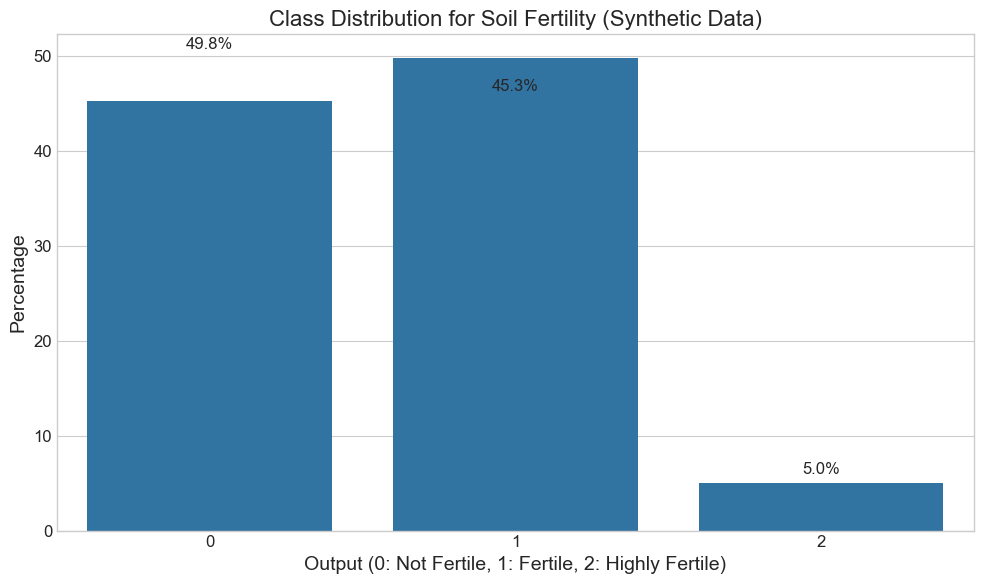

In [27]:
# Check class distribution
class_counts = data['Output'].value_counts()
print("Class distribution:")
print(class_counts)

# Visualize class distribution
plt.figure(figsize=(10, 6))
class_percentages = data['Output'].value_counts(normalize=True) * 100
sns.barplot(x=class_percentages.index, y=class_percentages.values)
plt.title('Class Distribution for Soil Fertility (Synthetic Data)', fontsize=16)
plt.xlabel('Output (0: Not Fertile, 1: Fertile, 2: Highly Fertile)', fontsize=14)
plt.ylabel('Percentage', fontsize=14)

# Add percentage labels on top of bars
for i, v in enumerate(class_percentages.values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12)

plt.tight_layout()
plt.show()

## 3. Exploratory Data Analysis

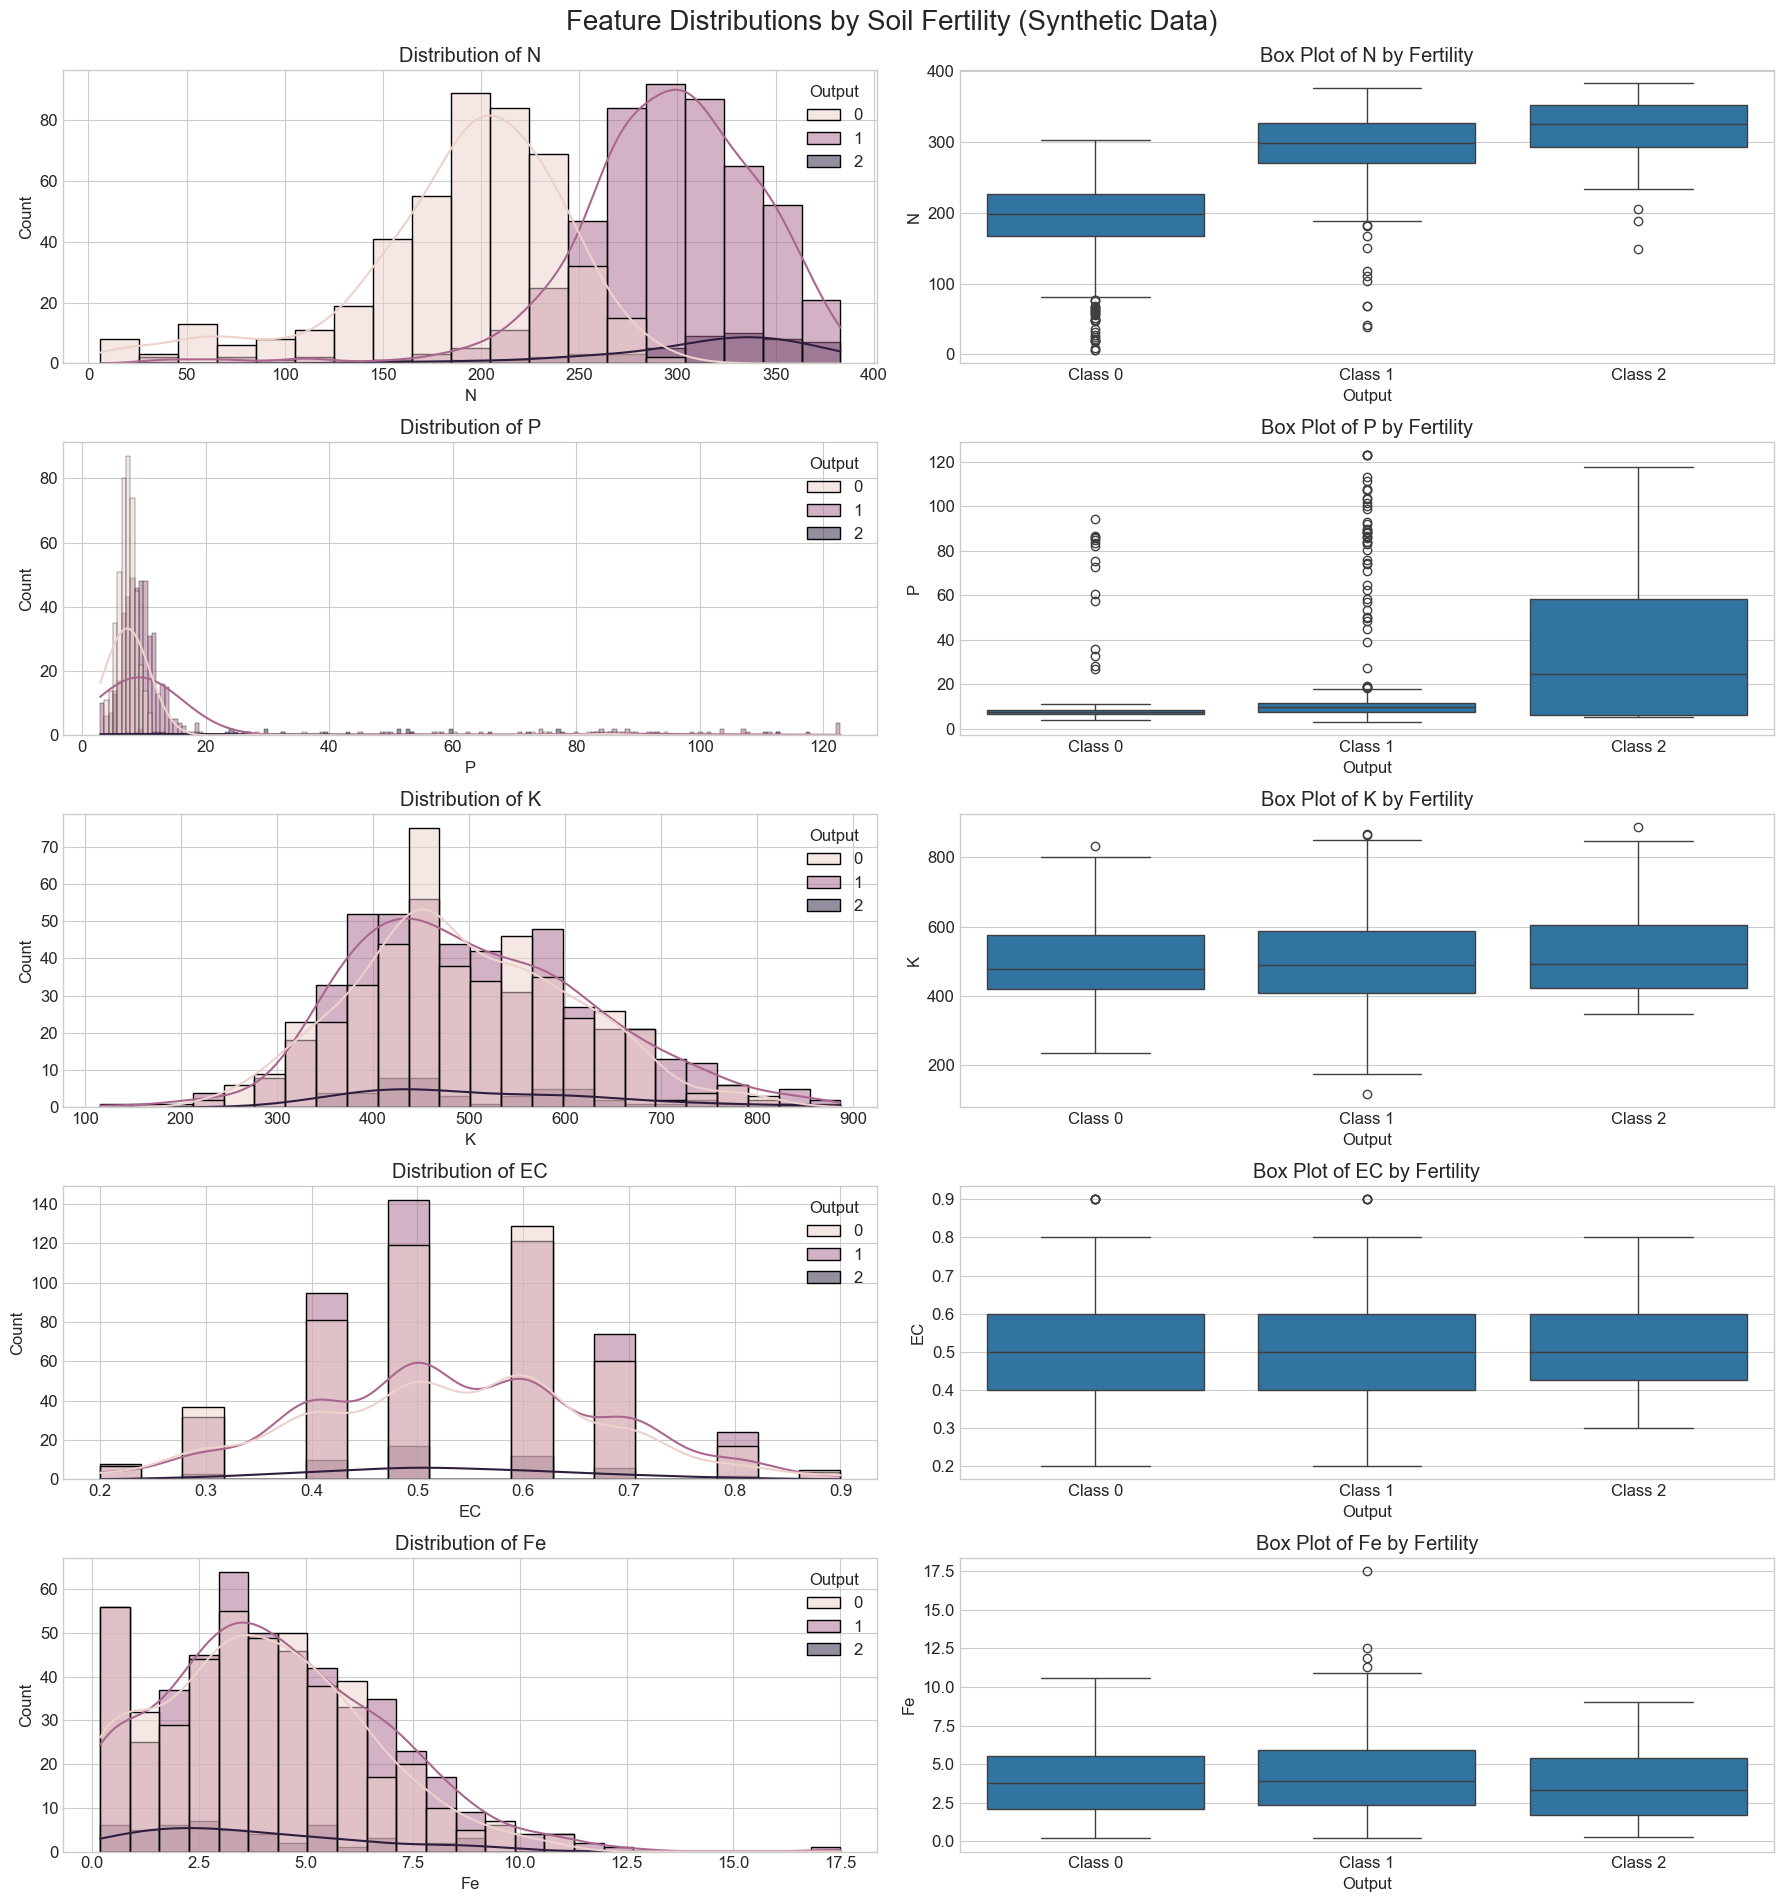

In [28]:
# Visualize the distribution of features
features = data.columns[:-1]  # All columns except the target 'Output'

fig, axes = plt.subplots(len(features), 2, figsize=(18, 20))
fig.suptitle('Feature Distributions by Soil Fertility (Synthetic Data)', fontsize=20, y=0.95)

for i, feature in enumerate(features):
    # Histogram
    sns.histplot(data=data, x=feature, hue='Output', kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribution of {feature}')
    
    # Box plot
    sns.boxplot(data=data, x='Output', y=feature, ax=axes[i, 1])
    axes[i, 1].set_title(f'Box Plot of {feature} by Fertility')
    
    # Set fixed tick positions
    axes[i, 1].set_xticks(range(len(data['Output'].unique())))
    axes[i, 1].set_xticklabels([f'Class {i}' for i in sorted(data['Output'].unique())])

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

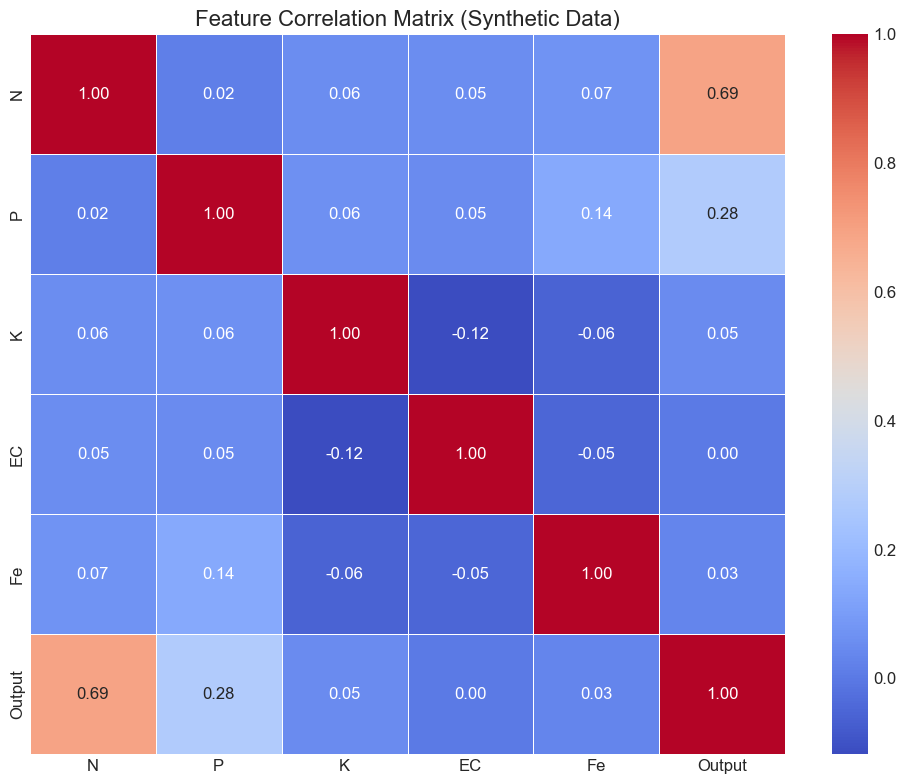

In [29]:
# Correlation matrix and heatmap
correlation = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix (Synthetic Data)', fontsize=16)
plt.tight_layout()
plt.show()

<Figure size 2000x1600 with 0 Axes>

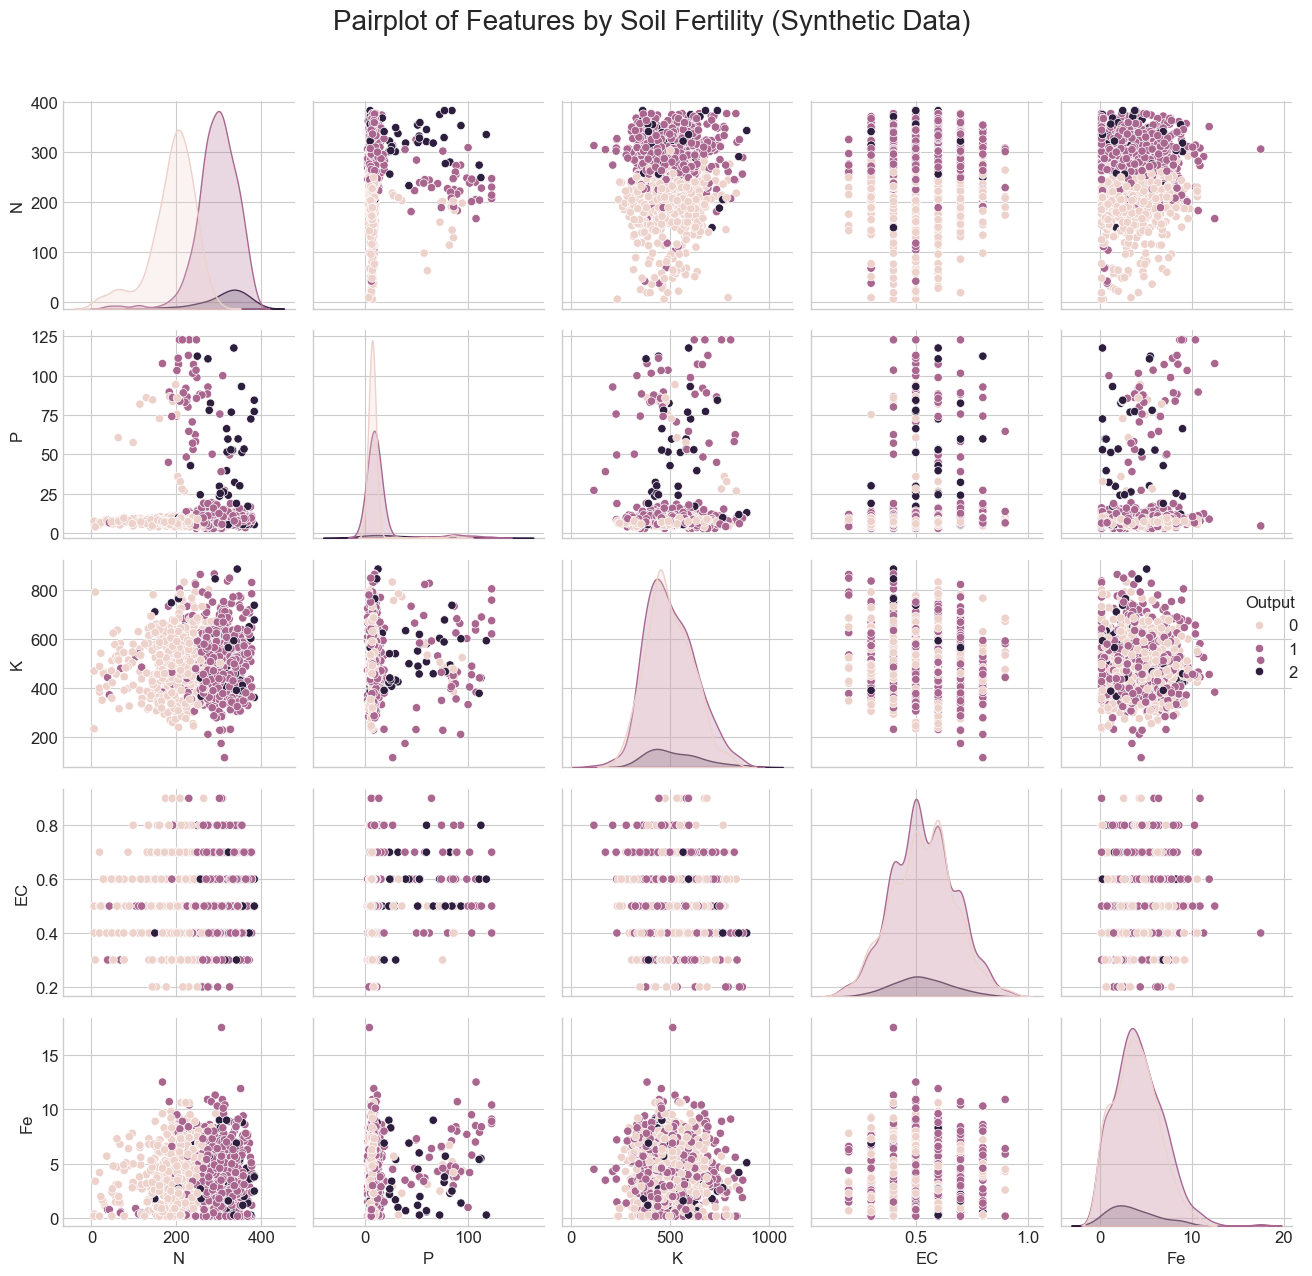

In [30]:
# Pairplot to visualize relationships between features
plt.figure(figsize=(20, 16))
sns.pairplot(data, hue='Output', diag_kind='kde')
plt.suptitle('Pairplot of Features by Soil Fertility (Synthetic Data)', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

## 4. Data Preprocessing

In [31]:
# Separate features and target
X = data.drop('Output', axis=1)
y = data['Output']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Verify class distribution in splits
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True) * 100)
print("\nClass distribution in testing set:")
print(y_test.value_counts(normalize=True) * 100)

Training set shape: (804, 5)
Testing set shape: (201, 5)

Class distribution in training set:
Output
1    49.751244
0    45.273632
2     4.975124
Name: proportion, dtype: float64

Class distribution in testing set:
Output
1    49.751244
0    45.273632
2     4.975124
Name: proportion, dtype: float64


## 5. Model Training with Hyperparameter Tuning

In [32]:
# Define the pipeline (scaling + KNN)
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('classifier', KNeighborsClassifier())
])

# Define the hyperparameter search space
param_grid = {
    'classifier__n_neighbors': list(range(1, 31)),  # Test k values from 1 to 30
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski'],
    'classifier__p': [1, 2]  # 1 for manhattan, 2 for euclidean (when metric is minkowski)
}

# Run grid search
print("Performing grid search with 5-fold cross-validation...")
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Get best model
best_model = grid_search.best_estimator_

Performing grid search with 5-fold cross-validation...
Fitting 5 folds for each of 360 candidates, totalling 1800 fits

Best parameters: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 9, 'classifier__p': 1, 'classifier__weights': 'distance'}
Best cross-validation score: 0.8881

Best parameters: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 9, 'classifier__p': 1, 'classifier__weights': 'distance'}
Best cross-validation score: 0.8881


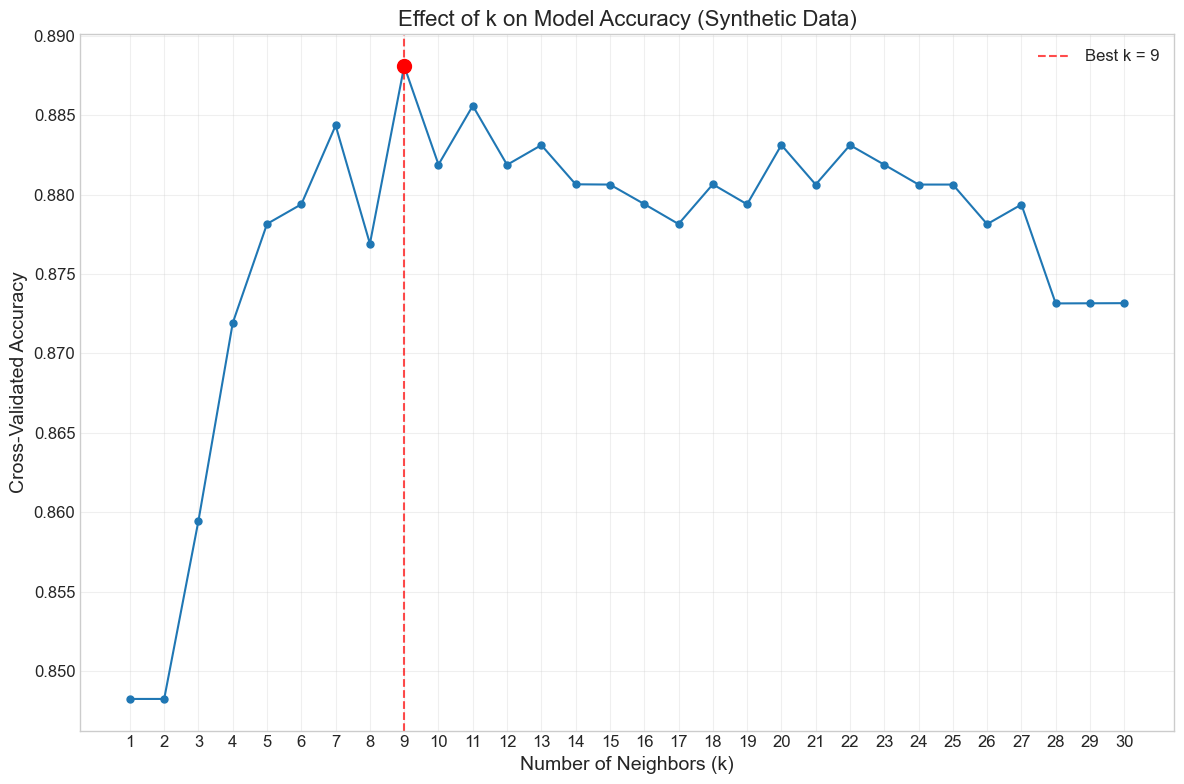

In [33]:
# Plot the effect of the number of neighbors (k) on model performance
k_range = list(range(1, 31))
k_scores = []

for k in k_range:
    knn = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', KNeighborsClassifier(
            n_neighbors=k,
            weights=grid_search.best_params_['classifier__weights'],
            metric=grid_search.best_params_['classifier__metric'],
            p=grid_search.best_params_['classifier__p']
        ))
    ])
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())

# Plot
plt.figure(figsize=(12, 8))
plt.plot(k_range, k_scores, marker='o', markersize=5)
plt.title('Effect of k on Model Accuracy (Synthetic Data)', fontsize=16)
plt.xlabel('Number of Neighbors (k)', fontsize=14)
plt.ylabel('Cross-Validated Accuracy', fontsize=14)
plt.xticks(k_range)
plt.grid(True, alpha=0.3)

# Mark the best k value
best_k = grid_search.best_params_['classifier__n_neighbors']
best_k_score = k_scores[best_k - 1]  # -1 because list is 0-indexed
plt.axvline(x=best_k, color='red', linestyle='--', alpha=0.7, label=f'Best k = {best_k}')
plt.plot(best_k, best_k_score, 'ro', markersize=10)
plt.legend()

plt.tight_layout()
plt.show()

## 6. Model Evaluation

In [34]:
# Make predictions
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.4f}")

# Training accuracy
train_accuracy = accuracy_score(y_train, best_model.predict(X_train))
print(f"Training accuracy: {train_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))

Test accuracy: 0.8806
Training accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91        91
           1       0.85      0.94      0.90       100
           2       0.50      0.10      0.17        10

    accuracy                           0.88       201
   macro avg       0.76      0.65      0.66       201
weighted avg       0.87      0.88      0.87       201



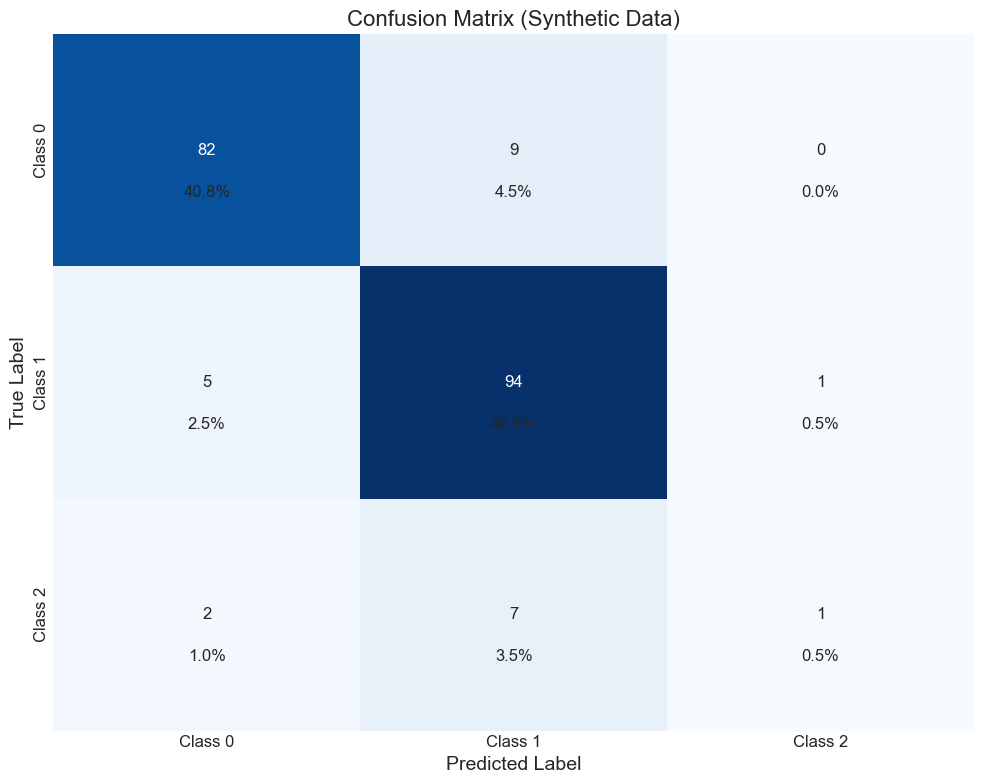

In [35]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    cbar=False,
    xticklabels=[f'Class {i}' for i in sorted(data['Output'].unique())],
    yticklabels=[f'Class {i}' for i in sorted(data['Output'].unique())]
)

plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.title('Confusion Matrix (Synthetic Data)', fontsize=16)

# Add text annotations with percentages
total = np.sum(conf_matrix)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(
            j + 0.5, 
            i + 0.7, 
            f"{conf_matrix[i, j] / total * 100:.1f}%", 
            ha="center", 
            fontsize=12
        )

plt.tight_layout()
plt.show()

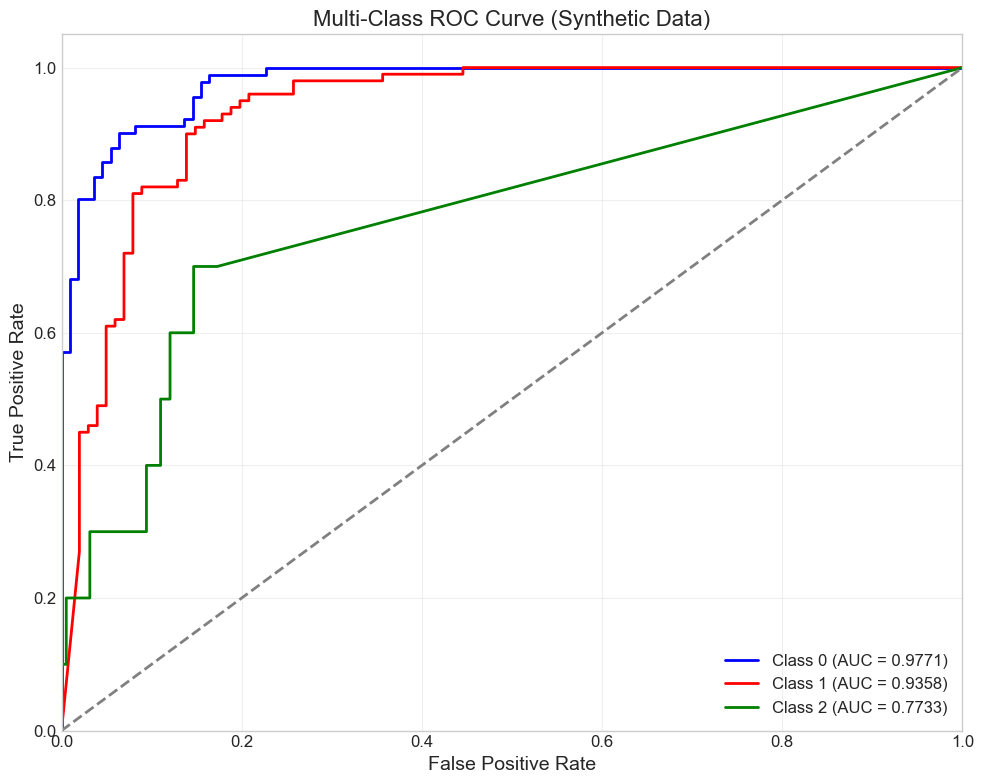

In [36]:
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get unique classes
classes = sorted(data['Output'].unique())
n_classes = len(classes)

# Ensure y_test is binarized for multi-class classification
y_test_bin = label_binarize(y_test, classes=classes)

# Make sure y_prob is properly generated
y_prob = best_model.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
colors = cycle(["blue", "red", "green"])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"Class {classes[i]} (AUC = {roc_auc[i]:.4f})")

plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("Multi-Class ROC Curve (Synthetic Data)", fontsize=16)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

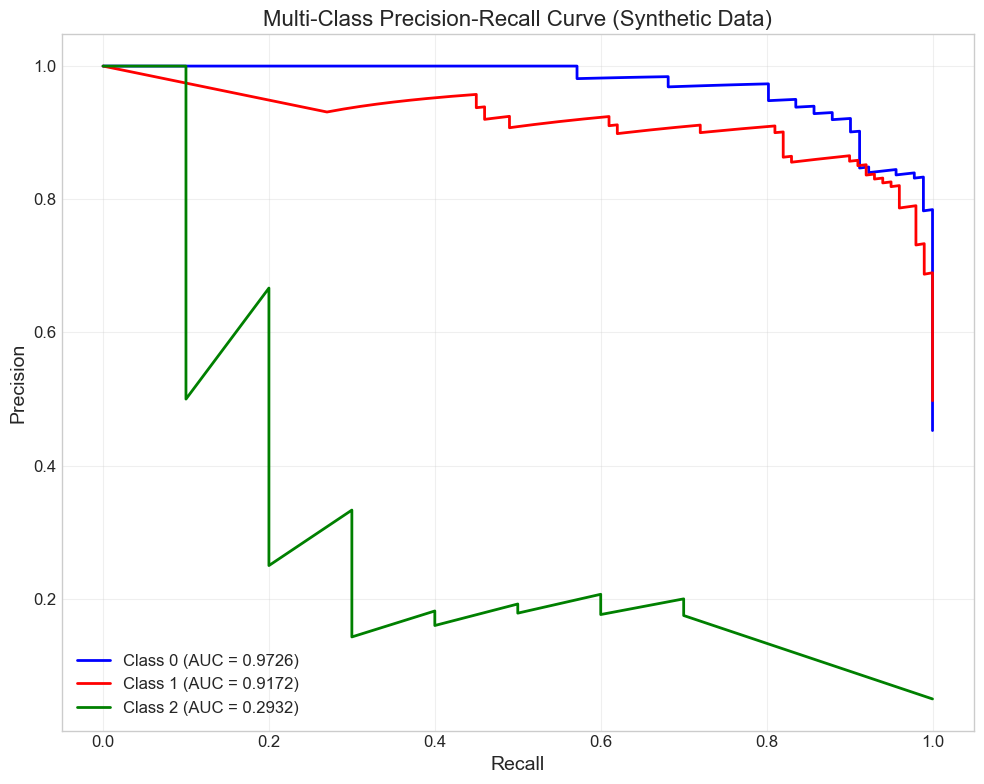

In [37]:
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Get unique classes
classes = sorted(data['Output'].unique())
n_classes = len(classes)

# Binarize the labels for multi-class precision-recall curves
y_test_bin = label_binarize(y_test, classes=classes)

# Ensure y_prob is in the correct format
y_prob = best_model.predict_proba(X_test)

# Compute Precision-Recall curve for each class
precision = dict()
recall = dict()
pr_auc = dict()

plt.figure(figsize=(10, 8))
colors = cycle(["blue", "red", "green"])

for i, color in zip(range(n_classes), colors):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

    plt.plot(recall[i], precision[i], color=color, lw=2, label=f"Class {classes[i]} (AUC = {pr_auc[i]:.4f})")

plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Multi-Class Precision-Recall Curve (Synthetic Data)", fontsize=16)
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

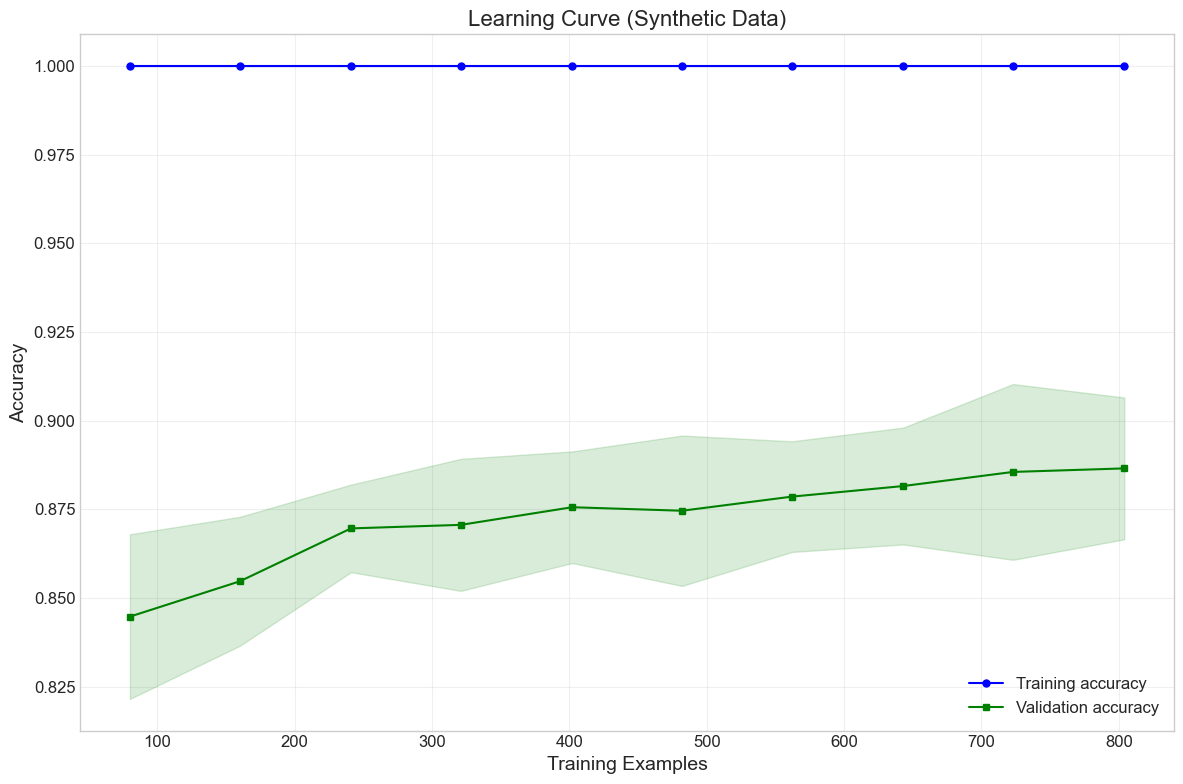

In [38]:
# Learning curve to assess overfitting/underfitting
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(12, 8))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.title('Learning Curve (Synthetic Data)', fontsize=16)
plt.xlabel('Training Examples', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right', fontsize=12)
plt.tight_layout()
plt.show()

## 7. Save the Trained Model

In [39]:
# Define the directory for saving models
model_dir = 'trained_models'
os.makedirs(model_dir, exist_ok=True)

# Save the model
model_path = os.path.join(model_dir, 'knn_synthetic.pkl')
joblib.dump(best_model, model_path)

print(f"Model saved to {model_path}")

Model saved to trained_models\knn_synthetic.pkl


## 8. Model Application - Prediction Function

In [40]:
def predict_soil_fertility(model, n, p, k, ec, fe):
    """
    Predict soil fertility using the trained model.
    
    Parameters:
    - model: Trained KNN model
    - n: Nitrogen level
    - p: Phosphorus level
    - k: Potassium level
    - ec: Electrical Conductivity
    - fe: Iron level
    
    Returns:
    - prediction: Fertility class (0, 1, or 2)
    - probabilities: Probability of each class
    """
    # Create a DataFrame with the input values
    input_data = pd.DataFrame({
        'N': [n],
        'P': [p],
        'K': [k],
        'EC': [ec],
        'Fe': [fe]
    })
    
    # Make prediction
    prediction = model.predict(input_data)[0]
    probabilities = model.predict_proba(input_data)[0]
    
    return prediction, probabilities

In [41]:
# Example usage - test with some sample data
# Sample 1 (expected to be not fertile)
sample1 = {'N': 150, 'P': 8.0, 'K': 500, 'EC': 0.5, 'Fe': 1.0}
# Sample 2 (expected to be fertile)
sample2 = {'N': 280, 'P': 10.0, 'K': 450, 'EC': 0.4, 'Fe': 3.0}
# Sample 3 (expected to be highly fertile)
sample3 = {'N': 325, 'P': 12.0, 'K': 500, 'EC': 0.5, 'Fe': 4.0}

def predict_soil_fertility_from_dict(model, sample_data):
    """Predict soil fertility using the trained model."""
    # Convert dict to DataFrame
    sample_df = pd.DataFrame([sample_data])
    prediction = model.predict(sample_df)[0]
    probabilities = model.predict_proba(sample_df)[0]
    return prediction, probabilities

# Make predictions
pred1, prob1 = predict_soil_fertility_from_dict(best_model, sample1)
pred2, prob2 = predict_soil_fertility_from_dict(best_model, sample2)
pred3, prob3 = predict_soil_fertility_from_dict(best_model, sample3)

# Define class labels for interpretation
fertility_classes = {0: "Not Fertile", 1: "Fertile", 2: "Highly Fertile"}

# Print results
print("Sample 1:")
print(f"Input: {sample1}")
print(f"Prediction: {fertility_classes.get(pred1, f'Class {pred1}')} (Class {pred1})")
print(f"Probability distribution: {prob1}")

print("\nSample 2:")
print(f"Input: {sample2}")
print(f"Prediction: {fertility_classes.get(pred2, f'Class {pred2}')} (Class {pred2})")
print(f"Probability distribution: {prob2}")

print("\nSample 3:")
print(f"Input: {sample3}")
print(f"Prediction: {fertility_classes.get(pred3, f'Class {pred3}')} (Class {pred3})")
print(f"Probability distribution: {prob3}")

Sample 1:
Input: {'N': 150, 'P': 8.0, 'K': 500, 'EC': 0.5, 'Fe': 1.0}
Prediction: Not Fertile (Class 0)
Probability distribution: [0.60080066 0.39919934 0.        ]

Sample 2:
Input: {'N': 280, 'P': 10.0, 'K': 450, 'EC': 0.4, 'Fe': 3.0}
Prediction: Fertile (Class 1)
Probability distribution: [0.         0.90965673 0.09034327]

Sample 3:
Input: {'N': 325, 'P': 12.0, 'K': 500, 'EC': 0.5, 'Fe': 4.0}
Prediction: Fertile (Class 1)
Probability distribution: [0. 1. 0.]


## 9. Comparison with Original KNN Model

Let's compare the KNN model trained on synthetic data with the original KNN model.

In [42]:
# Load the original KNN model
orig_knn_model_path = os.path.join(model_dir, 'knn.pkl')

models_to_compare = {}

if os.path.exists(orig_knn_model_path):
    models_to_compare['Original'] = joblib.load(orig_knn_model_path)
    
models_to_compare['Synthetic'] = best_model

# Compare predictions if we have at least one model to compare with
if len(models_to_compare) > 1:
    # Test samples
    test_samples = [sample1, sample2, sample3]
    
    print("Comparing predictions across different models:")
    
    for i, sample in enumerate(test_samples):
        print(f"\nSample {i+1}:")
        
        for model_name, model in models_to_compare.items():
            pred, prob = predict_soil_fertility_from_dict(model, sample)
            confidence = np.max(prob)
            print(f"{model_name} KNN model prediction: {fertility_classes.get(pred, f'Class {pred}')} (confidence: {confidence:.4f})")
else:
    print("Original KNN model file not found. Cannot compare models.")

Comparing predictions across different models:

Sample 1:
Original KNN model prediction: Not Fertile (confidence: 0.8750)
Synthetic KNN model prediction: Not Fertile (confidence: 0.6008)

Sample 2:
Original KNN model prediction: Fertile (confidence: 0.7500)
Synthetic KNN model prediction: Fertile (confidence: 0.9097)

Sample 3:
Original KNN model prediction: Fertile (confidence: 0.7083)
Synthetic KNN model prediction: Fertile (confidence: 1.0000)


## 10. Conclusions and Next Steps

### Summary
In this notebook, we have:
1. Loaded and explored the synthetic soil fertility dataset
2. Built a K-Nearest Neighbors model for classifying soil fertility using synthetic data
3. Optimized the model through hyperparameter tuning
4. Evaluated model performance using various metrics and visualizations
5. Compared the synthetic data KNN model with the original KNN model
6. Saved the trained model for future use
7. Created an interactive prediction interface

### Key Insights
- The KNN model's performance metrics on synthetic data show how well the model generalizes to data that maintains the statistical properties of the original dataset
- The synthetic data helps evaluate the stability of the KNN model by providing additional test cases
- Comparison between models trained on original vs. synthetic data helps assess the quality of the synthetic dataset

### Next Steps
1. Implement the KNN model using realistic data
2. Implement additional models (SVM, Random Forest) on all datasets
3. Compare performance across all models and datasets
4. Create ensemble methods that combine multiple models for potentially better performance
5. Integrate the model with IoT sensors for real-time soil parameter readings
6. Develop the .NET MAUI application interface for user-friendly access to predictions

This KNN model trained on synthetic data serves as an important component in creating a robust soil fertility prediction system for the SDP_Agri_Swastha project.